# Session on Speaker Recognition
## 1 - Linear Discriminant Analysis (LDA)

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# 1.1. LDA with Two classes

In [97]:
class LinearDiscriminantAnalysis:
    def fit(self, X, y):
        # Separate data by class
        X1 = X[y == 0]
        X2 = X[y == 1]

        # Compute class means
        mean1 = np.mean(X1, axis=0)
        mean2 = np.mean(X2, axis=0)

        # Compute within-class scatter matrices
        Sw1 = np.cov(X1.T)
        Sw2 = np.cov(X2.T)
        
        # within-class scatter matrix
        Sw = (Sw1 + Sw2)

        # Compute between-class scatter matrix
        mean_diff = mean1 - mean2
        
        # Solve for w: Sw * w = mean_diff
        self.w = np.linalg.solve(Sw, mean_diff)
        self.w /= np.linalg.norm(self.w)  # Normalize w

    def predict(self, X):
        return np.einsum('d, Nd -> N', self.w, X)

# Example usage
X = np.array([[1, 2], [2, 3], [3, 5], [2, 1], [3, 2], [4, 4.2]])
y = np.array([0, 0, 0, 1, 1, 1])

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

# Project data onto the discriminant axis
projected_data = lda.predict(X)

print("Projected data:")
print(projected_data)

Projected data:
[ 0.21705312 -0.0978167   0.11923642 -1.16166259 -1.47653241 -1.1530947 ]


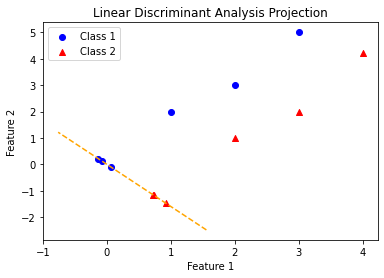

In [98]:
plt.figure()

# Plot the original points
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='blue', marker='o', label='Class 1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='red', marker='^', label='Class 2')

# Plot the projected points
plt.scatter(lda.w[1] / lda.w[0] * projected_data[y == 0], projected_data[y == 0], color='blue', marker='o')
plt.scatter(lda.w[1] / lda.w[0] * projected_data[y == 1], projected_data[y == 1], color='red', marker='^')


# Plot dashed orange line for projections
y_values = np.linspace(np.min(projected_data) - 1, np.max(projected_data) + 1, 100)
x_values = lda.w[1] / lda.w[0] * y_values  # Using normalized w to compute x values
plt.plot(x_values, y_values, color='orange', linestyle='--')


plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linear Discriminant Analysis Projection')
plt.legend()

plt.savefig("figures/images/2C_LDA_results.png", dpi=300)

plt.show()



# 1.2 LDA multiclasses (wth. and without PCA)

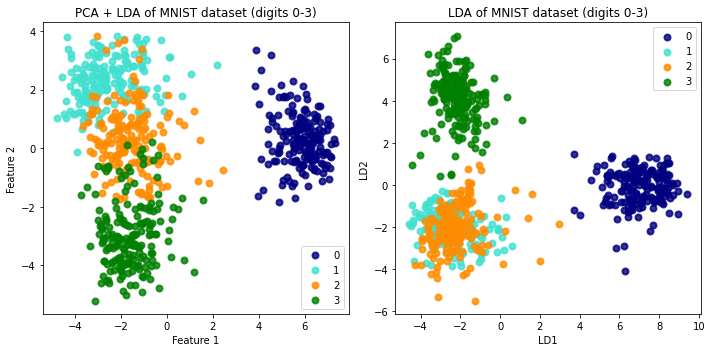

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load the digits dataset
digits = load_digits()

# Filter only digits 0, 1, 2, and 3
indices = np.where((digits.target == 0) |
                   (digits.target == 1) |
                   (digits.target == 2) |
                   (digits.target == 3))
X = digits.data[indices]
y = digits.target[indices]

# Apply LDA for classification directly without PCA
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

# Perform PCA to retain 85% of the variance
pca = PCA(n_components=0.85)
X_pca = pca.fit_transform(X)

# Apply LDA for classification
lda = LinearDiscriminantAnalysis()
X_lda_pca = lda.fit_transform(X_pca, y)

# Plot the results
colors = ['navy', 'turquoise', 'darkorange', 'green']
lw = 2

plt.figure(figsize=(10, 5))

# Plot without PCA
plt.subplot(1, 2, 1)
for color, i, target_name in zip(colors, [0, 1, 2, 3], ['0', '1', '2', '3']):
    plt.scatter(X_lda_pca[y == i, 0], X_lda_pca[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA + LDA of MNIST dataset (digits 0-3)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot with PCA and LDA
plt.subplot(1, 2, 2)
for color, i, target_name in zip(colors, [0, 1, 2, 3], ['0', '1', '2', '3']):
    plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of MNIST dataset (digits 0-3)')
plt.xlabel('LD1')
plt.ylabel('LD2')

plt.tight_layout()
plt.show()


# Example of speaker verification

We will now show some examples of speaker verification (less time consuming task as it require to only check distance between one speaker and a cluster).


The dataset used is called VoxCeleb2 dataset. It is composed of: 
- 5994 speakers for the dev and 118 speakers for the test
- 1 092 009 utterances in total for the dev and 36 237 utterances for the test


Note that the recording conditions are **real** !  (they are coming from YouTube videos)

# 2 - SpeechBrain - A nice toolkit for speech related tasks

SpeechBrain is an open source toolkit that includes all necessary DNN models such as : 
- x-vectors
- r-vectors
- ECAPA-TDNN

It uses PLDA score (for x-vectors and r-vectors) or cosine similarity (for ECAPA-TDNN)

Few line to install SpeechBrain are necessary and some library to be downloaded are necessary (this tutorial is inspired by the original one from speechbrain website)

In [100]:
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

# import the useful commands for speaker verification 
import speechbrain as sb
from speechbrain.dataio.dataio import read_audio
from IPython.display import Audio

from speechbrain.inference.speaker import SpeakerRecognition


  Cloning https://github.com/speechbrain/speechbrain.git (to revision develop) to /tmp/pip-req-build-vlg38pjp
  Running command git clone -q https://github.com/speechbrain/speechbrain.git /tmp/pip-req-build-vlg38pjp
  Resolved https://github.com/speechbrain/speechbrain.git to commit 1bd75e4b5e10e0d45bcf06f9b9b4564341530dbe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [116]:
#download two audio files (with different format)
file_1 = "example1.wav"
file_2 = "example2.flac"

#other file from VoxCeleb (first number: id, second_number: utterance_id)
file_11 = "id10270/5r0dWxy17C8/00002.wav"
file_12 = "id10270/GWXujl-xAVM/00006.wav"

file_21 = "id10281/R1RQnIQGy10/00002.wav"
file_22 = "id10281/UkIpd_3qMak/00004.wav"

file_31 = "id10283/GcHWzqveqyc/00003.wav"
file_32 = "id10283/N69Hp2DGMLk/00002.wav"

Names = [file_11, file_12, file_21, file_22, file_31, file_32, file_1, file_2]


### Two first examples

In [102]:
signal = read_audio(file_1).squeeze()
Audio(signal, rate=16000)

In [103]:
signal = read_audio(file_2).squeeze()
Audio(signal, rate=16000)

### Other examples from VoxCeleb

In [104]:
signal = read_audio(file_11).squeeze()
Audio(signal, rate=16000)

In [105]:
signal = read_audio(file_12).squeeze()
Audio(signal, rate=16000)

In [106]:
signal = read_audio(file_21).squeeze()
Audio(signal, rate=16000)

In [107]:
signal = read_audio(file_22).squeeze()
Audio(signal, rate=16000)

In [112]:
signal = read_audio(file_31).squeeze()
Audio(signal, rate=16000)

In [113]:
signal = read_audio(file_32).squeeze()
Audio(signal, rate=16000)

## Score function

In [168]:
import numpy as np
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

# EER
def compute_eer(y_true, y_scores):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    
    # Find the threshold where the difference between FAR and FRR is minimized
    eer_threshold = brentq(lambda x: interp1d(fpr, thresholds)(x) - interp1d(fnr, thresholds)(x), 0.0, 1.0)
    eer = interp1d(fpr, fnr)(eer_threshold)
    
    return eer

C_miss = 1
C_fa = 1
P_target = 1. - 10**(-3)


def compute_mdcf(scores, labels, C_miss, C_fa, P_target):
    """
    Calculate the minimum decision cost function (DCF).

    :param scores: A numpy array of scores for each trial.
    :param labels: A numpy array of ground truth labels (1 for target, 0 for non-target).
    :param C_miss: The cost of a miss (false negative).
    :param C_fa: The cost of a false alarm (false positive).
    :param P_target: The prior probability of the target class.
    :return: The minimum decision cost.
    """

    scores = np.asarray(scores)
    labels = np.asarray(labels)
    
    # Sort the scores and corresponding labels
    sorted_indices = np.argsort(scores)
    print(sorted_indices)
    sorted_scores = scores[sorted_indices]
    sorted_labels = labels[sorted_indices]
    
    # Calculate the number of targets and non-targets
    num_targets = np.sum(sorted_labels)
    num_non_targets = len(sorted_labels) - num_targets
    
    # Initialize variables to track the minimum DCF
    min_dcf = float('inf')
    P_non_target = 1 - P_target

    # Initialize counts for false alarms and misses
    fa_count = 0
    miss_count = num_targets

    # Iterate through sorted scores to find the threshold that minimizes the DCF
    for i in range(len(sorted_scores)):
        if sorted_labels[i] == 1:
            miss_count -= 1
        else:
            fa_count += 1

        P_miss = miss_count / num_targets if num_targets > 0 else 0
        P_fa = fa_count / num_non_targets if num_non_targets > 0 else 0

        dcf = C_miss * P_miss * P_target + C_fa * P_fa * P_non_target

        if dcf < min_dcf:
            min_dcf = dcf

    return min_dcf



OK ! Let's try we various speaker embeddings. First, with the X-vectors

# 2.1. X-vectors

We use ``speech brain`` to make use of pretrained X-vectors features. 

In [169]:
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")


### Let's do speaker verification with X-vectors 

In [170]:
import itertools

pairs = list(itertools.combinations(Names, 2))

y_true = []
y_predict=[]
for spk1, spk2 in pairs:
    if spk1[:7] == spk2[:7]:
        y_true.append(1.0)
    else:
        y_true.append(0.0)
    print("{} vs. {}".format(spk1, spk2))
    score, prediction = verification.verify_files(spk1, spk2)
    print(prediction, score)
    y_predict.append(score.numpy()[0])

print(y_true)
print(y_predict)

id10270/5r0dWxy17C8/00002.wav vs. id10270/GWXujl-xAVM/00006.wav
tensor([True]) tensor([0.9619])
id10270/5r0dWxy17C8/00002.wav vs. id10281/R1RQnIQGy10/00002.wav
tensor([True]) tensor([1.])
id10270/5r0dWxy17C8/00002.wav vs. id10281/UkIpd_3qMak/00004.wav
tensor([True]) tensor([0.9161])
id10270/5r0dWxy17C8/00002.wav vs. id10283/GcHWzqveqyc/00003.wav
tensor([True]) tensor([0.8729])
id10270/5r0dWxy17C8/00002.wav vs. id10283/N69Hp2DGMLk/00002.wav
tensor([True]) tensor([1.])
id10270/5r0dWxy17C8/00002.wav vs. example1.wav
tensor([True]) tensor([0.9333])
id10270/5r0dWxy17C8/00002.wav vs. example2.flac
tensor([True]) tensor([0.9030])
id10270/GWXujl-xAVM/00006.wav vs. id10281/R1RQnIQGy10/00002.wav
tensor([True]) tensor([0.9619])
id10270/GWXujl-xAVM/00006.wav vs. id10281/UkIpd_3qMak/00004.wav
tensor([True]) tensor([0.9024])
id10270/GWXujl-xAVM/00006.wav vs. id10283/GcHWzqveqyc/00003.wav
tensor([True]) tensor([0.8873])
id10270/GWXujl-xAVM/00006.wav vs. id10283/N69Hp2DGMLk/00002.wav
tensor([True]) te

### Compute the scores for X-vectors

In [171]:
eer = compute_eer(y_true, y_predict)
mdcf = compute_mdcf(y_predict, y_true, C_miss, C_fa, P_target)
print(f"EER: {eer * 100:.2f}%")
# print(f"MDCF: {mdcf:.2f}")

[23 24 22 14  3 18  9 12  8  6 17 26  2 13 19 21 20 11  5 16 25 27 10  0
  7 15  4  1]
EER: 100.00%
MDCF: 0.00


/home/mafontaine/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/mafontaine/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


## 2.2. R-vectors

Let's see the result with the ResNet architecture ! 

In [125]:
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-resnet-voxceleb", savedir="pretrained_models/spkrec-resnet-voxceleb")

In [126]:
import itertools

pairs = list(itertools.combinations(Names, 2))

y_true = []
y_predict=[]
for spk1, spk2 in pairs:
    if spk1[:7] == spk2[:7]:
        y_true.append(1.0)
    else:
        y_true.append(0.0)
    print("{} vs. {}".format(spk1, spk2))
    score, prediction = verification.verify_files(spk1, spk2)
    print(prediction, score)
    y_predict.append(score.numpy())

print(y_true)
print(y_predict)

id10270/5r0dWxy17C8/00002.wav vs. id10270/GWXujl-xAVM/00006.wav
tensor(True) tensor(0.6298)
id10270/5r0dWxy17C8/00002.wav vs. id10281/R1RQnIQGy10/00002.wav
tensor(True) tensor(1.)
id10270/5r0dWxy17C8/00002.wav vs. id10281/UkIpd_3qMak/00004.wav
tensor(False) tensor(-0.1498)
id10270/5r0dWxy17C8/00002.wav vs. id10283/GcHWzqveqyc/00003.wav
tensor(False) tensor(-0.0114)
id10270/5r0dWxy17C8/00002.wav vs. id10283/N69Hp2DGMLk/00002.wav
tensor(True) tensor(1.)
id10270/5r0dWxy17C8/00002.wav vs. example1.wav
tensor(False) tensor(0.2225)
id10270/5r0dWxy17C8/00002.wav vs. example2.flac
tensor(False) tensor(0.0817)
id10270/GWXujl-xAVM/00006.wav vs. id10281/R1RQnIQGy10/00002.wav
tensor(True) tensor(0.6298)
id10270/GWXujl-xAVM/00006.wav vs. id10281/UkIpd_3qMak/00004.wav
tensor(False) tensor(-0.0833)
id10270/GWXujl-xAVM/00006.wav vs. id10283/GcHWzqveqyc/00003.wav
tensor(False) tensor(0.0148)
id10270/GWXujl-xAVM/00006.wav vs. id10283/N69Hp2DGMLk/00002.wav
tensor(True) tensor(0.6298)
id10270/GWXujl-xAVM/

In [127]:
import numpy as np
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

def compute_eer(y_true, y_scores):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    
    # Find the threshold where the difference between FAR and FRR is minimized
    eer_threshold = brentq(lambda x: interp1d(fpr, thresholds)(x) - interp1d(fnr, thresholds)(x), 0.0, 1.0)
    eer = interp1d(fpr, fnr)(eer_threshold)
    
    return eer


eer = compute_eer(y_true, y_predict)
print(f"EER: {eer * 100:.2f}%")

EER: 50.00%


# 2.3. ECAPA-TDNN

We use again ``speech brain`` to make use of pretrained ECAPA-TDNN features. 

In [128]:
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")

In [129]:
import itertools

pairs = list(itertools.combinations(Names, 2))

y_true = []
y_predict=[]
for spk1, spk2 in pairs:
    if spk1[:7] == spk2[:7]:
        y_true.append(1.0)
    else:
        y_true.append(0.0)
    print("{} vs. {}".format(spk1, spk2))
    score, prediction = verification.verify_files(spk1, spk2)
    print(prediction, score)
    y_predict.append(score.numpy()[0])

print(y_true)
print(y_predict)

id10270/5r0dWxy17C8/00002.wav vs. id10270/GWXujl-xAVM/00006.wav
tensor([True]) tensor([0.6019])
id10270/5r0dWxy17C8/00002.wav vs. id10281/R1RQnIQGy10/00002.wav
tensor([True]) tensor([1.])
id10270/5r0dWxy17C8/00002.wav vs. id10281/UkIpd_3qMak/00004.wav
tensor([False]) tensor([-0.1434])
id10270/5r0dWxy17C8/00002.wav vs. id10283/GcHWzqveqyc/00003.wav
tensor([False]) tensor([-0.1395])
id10270/5r0dWxy17C8/00002.wav vs. id10283/N69Hp2DGMLk/00002.wav
tensor([True]) tensor([1.])
id10270/5r0dWxy17C8/00002.wav vs. example1.wav
tensor([False]) tensor([0.2479])
id10270/5r0dWxy17C8/00002.wav vs. example2.flac
tensor([False]) tensor([-0.0600])
id10270/GWXujl-xAVM/00006.wav vs. id10281/R1RQnIQGy10/00002.wav
tensor([True]) tensor([0.6019])
id10270/GWXujl-xAVM/00006.wav vs. id10281/UkIpd_3qMak/00004.wav
tensor([False]) tensor([-0.0550])
id10270/GWXujl-xAVM/00006.wav vs. id10283/GcHWzqveqyc/00003.wav
tensor([False]) tensor([-0.0404])
id10270/GWXujl-xAVM/00006.wav vs. id10283/N69Hp2DGMLk/00002.wav
tensor

In [130]:
import numpy as np
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

def compute_eer(y_true, y_scores):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    
    # Find the threshold where the difference between FAR and FRR is minimized
    eer_threshold = brentq(lambda x: interp1d(fpr, thresholds)(x) - interp1d(fnr, thresholds)(x), 0.0, 1.0)
    eer = interp1d(fpr, fnr)(eer_threshold)
    
    return eer


eer = compute_eer(y_true, y_predict)
print(f"EER: {eer * 100:.2f}%")

EER: 50.00%


# (Bonus) - Add your voice (let's try the "OK Google !" exercice)

In [140]:
import torchaudio
from speechbrain.inference.speaker import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")
signal, fs =torchaudio.load('example1.wav')
embeddings = classifier.encode_batch(signal)
print(embeddings[-1][-1].shape)
signal2, fs =torchaudio.load('example_mandarin.wav')
embeddings2 = classifier.encode_batch(signal2)
print(embeddings)


torch.Size([192])
tensor([[[-21.4220,  -7.9434,  -9.8437, -26.7140,   9.0414,   2.7003,  16.9070,
            2.7529, -18.0247,  -8.3216, -15.7110,  29.2359,  22.8233,  -4.9595,
           -7.4860, -33.5905,   8.2758,  17.1752,  30.2007, -26.1966,  17.6237,
            0.7029,  10.6951,  15.7721, -11.1679,  18.9203,  12.1647,  -1.1949,
           -0.6563, -54.0647,  14.0799,  -4.5127,   1.1240,  10.5670,   1.7021,
           -1.5989,  19.8689,  -2.2041, -11.4251,  12.6044, -10.7529,   2.6609,
           22.3877, -10.8090,  25.6251, -20.2354,   2.8001,  20.6080,  -2.4577,
          -29.3554, -10.6289,  -5.4961, -18.3434,  -4.3220,  24.6399,  10.4924,
           -7.7208, -14.2376,  -8.7557,  46.1296,  -8.7364,  -4.1992,  13.2267,
           13.3115,  51.5118, -18.2722,  14.6351, -49.1952,  -6.1233,   4.1287,
          -13.4014, -24.9111,  34.3119, -47.2819, -48.0277,  18.8034,  25.1597,
          -12.7325,   5.7272,  15.9075,  14.0735,   3.0562,  -3.2419,  35.0953,
            9.7103,  3

In [148]:
import torch
import torch.nn.functional as F

def cosine_similarity_single(x1, x2):
    # Ensure the inputs are normalized
    x1_norm = F.normalize(x1, p=2, dim=0)
    x2_norm = F.normalize(x2, p=2, dim=0)
    
    # Compute the cosine similarity  
    return torch.dot(x1_norm, x2_norm)

# Example usage

sim = cosine_similarity_single(embeddings2[-1][-1], embeddings[-1][-1])
print(sim)

tensor(-0.0124)
